# PepoG Session \#1: 3-Star 4-Cost Units

by: [anathana](https://lolchess.gg/profile/na/anathana) - NA Challenger  

## A. Introduction: Why do we care about 3-Star 4-Cost Units?
- Making a 3-Star 4-Cost will almost always result in a 1st
- The probability of hitting a 3-Star 4-Cost is unclear
  - In most situations, players decide to roll at 8 for a 3-Star 4-Cost or to level to 9 based off gut feeling
  - This results in the following problems:
  - 1. Players that had a high probability of hitting a 3-Star 4-Cost (almost certainly a first) decide to level to 9 and instead only place Top 4
  - 2. Players that had a low probability of hitting a 3-Star 4-Cost decide to roll at 8 and then place lower than they would have if they had leveled to 9.
- Objective: **PROVIDE CLARITY** about the odds of hitting a 3-Star 4-Cost

## B. Simulate Rolls: How do units appear in the shop?
- At the beginning of every round, a players shop is *refreshed* - meaning that 5 new units appear in the players shop
  - Players have the option to refresh the shop again (5 new units appear) at the cost of 2 gold per roll
- For each roll / refresh, units are generated in the shop based off the following two rules:
- 1. Cost of unit based off level
- 2. Type of unit based off the determined cost of unit.
  - Given a determined cost of unit, the type of unit is then selected at random from a shared pool of available units

## C. Simulation Construction.
- First, we can read in constant data such as champion data, number of units, and rolling probability

In [4]:
import numpy as np
import pandas as pd
from scipy.special import comb
import matplotlib.pyplot as plt
from IPython.display import Image

champion_data = pd.read_csv('data/tftset6champions.csv')
unit_pool_data = pd.read_json('data/unitpool.json', typ='series')
rolling_probability_data = pd.read_json('data/rollprobability.json')

np.set_printoptions(precision=6, linewidth=110)
pd.set_option('display.width', 100)

print('CHAMPION DATA:')
print(champion_data[['name', 'cost']].sample(frac=.1))
print('\nNUMBER OF UNITS:')
print(unit_pool_data)
print('\nROLLING PROBABILITY:')
rolling_probability_data.index += 1
print(rolling_probability_data)

CHAMPION DATA:
            name  cost
36         taric     3
6         illaoi     1
54         kaisa     5
8          poppy     1
33  miss_fortune     3
14      katarina     2

NUMBER OF UNITS:
1    29
2    22
3    18
4    12
5    10
dtype: int64

ROLLING PROBABILITY:
   1   2     3     4     5     6     7     8     9     10    11
1   1   1  0.75  0.55  0.45  0.25  0.19  0.15  0.10  0.05  0.01
2   0   0  0.25  0.30  0.33  0.40  0.30  0.20  0.15  0.10  0.02
3   0   0  0.00  0.15  0.20  0.30  0.35  0.35  0.30  0.20  0.12
4   0   0  0.00  0.00  0.20  0.50  0.15  0.25  0.30  0.40  0.50
5   0   0  0.00  0.00  0.00  0.00  0.01  0.05  0.15  0.25  0.35


## D. Roll Node Naive.
- Our first model will proceed as follows:
  - Each node represents a single state: \<Current number of units (the unit we are trying to 3-star)\>
  - All nodes share constant data \<Level, Cost of unit (the unit we are trying to 3-star)\>
  - A single roll is represented by moving from the left node, to the nodes on the right column

In [5]:
Image(url= "images/RollNodeNaive.png", width=800, height=800)

In [6]:
UNIT_MAX = None
POOL_MAX = None
P_N_COST = None
DIST_N_COST = None

def config_rolldown(level, n_cost):
    global UNIT_MAX, POOL_MAX, P_N_COST, DIST_N_COST
    UNIT_MAX = unit_pool_data[n_cost]
    POOL_MAX = UNIT_MAX * champion_data[champion_data['cost'] == n_cost]['cost'].size
    P_N_COST = rolling_probability_data[level][n_cost - 1]
    DIST_N_COST = binary_dist(5, P_N_COST)
    
def binary_dist(n, p):
    prob_density = np.zeros(n + 1)
    for k in range(n + 1):
        prob_density[k] = comb(n, k) * np.power(p, k) * np.power(1 - p, n - k)
    return prob_density

# row is number of unit pulled from bag, column is number of hits
def bag_dist(n, pool, unit):
    prob_density = np.zeros((n + 1, n + 1))
    for i in range(prob_density.shape[0]):
        for j in range(prob_density.shape[1]):
            prob_density[i][j] = comb(unit, j) * comb(pool - unit, i - j) / comb(pool, i)
    return prob_density

def roll_node_naive(current, current_contested=None, current_uncontested=None):
    bag_dist_array = bag_dist(5, POOL_MAX - current, UNIT_MAX - current)
    hit_dist_array = np.matmul(DIST_N_COST, bag_dist_array)
    return hit_dist_array

level = 8
n_cost = 4
config_rolldown(level, n_cost)

naive_roll_node_matrix = np.zeros((9, 6))
for current in np.arange(9):
    naive_roll_node_matrix[current] = roll_node_naive(current)

print('State probabilities of roll node naive:')
print('LEVEL: ' + str(level))
print('COST: ' + str(n_cost))
naive_roll_node_dataframe = pd.DataFrame(naive_roll_node_matrix).rename(columns={0: '+0', 1: '+1', 2: '+2', 3: '+3', 4: '+4', 5: '+5'})
naive_roll_node_dataframe.index.rename('Current', inplace=True)
print(naive_roll_node_dataframe)


State probabilities of roll node naive:
LEVEL: 8
COST: 4
               +0        +1        +2        +3            +4            +5
Current                                                                    
0        0.850012  0.141132  0.008614  0.000240  3.006593e-06  1.344802e-08
1        0.860775  0.131693  0.007345  0.000185  2.072493e-06  8.153525e-09
2        0.871816  0.121893  0.006151  0.000138  1.364039e-06  4.623860e-09
3        0.883146  0.111716  0.005038  0.000100  8.466949e-07  2.404407e-09
4        0.894775  0.101144  0.004012  0.000068  4.867725e-07  1.111715e-09
5        0.906714  0.090160  0.003082  0.000044  2.519371e-07  4.338401e-10
6        0.918974  0.078745  0.002255  0.000026  1.117991e-07  1.290344e-10
7        0.931567  0.066879  0.001540  0.000013  3.859835e-08  2.239440e-11
8        0.944507  0.054541  0.000947  0.000005  7.998000e-09  0.000000e+00


## E. Roll Node Improved.
- Because Units are in a shared pool, it will be harder to 3-star our unit if other players have that unit out of the pool. Similarily, it will be easier to 3-star our unit if other players have taken many same-cost units that do not contest our unit out of the pool.
- Therefore, we can consider 2 new fields in constant data: **Number of Units Contested**, **Number of Units Uncontested**
- Our second model will proceed as follows:
  - Each node represents a single state: \<Current number of units (the unit we are trying to 3-star)\>
  - All nodes share constant data \<Level, Cost of unit (the unit we are trying to 3-star), **Number of Units Contested**, **Number of Units Uncontested**\>
  - A single roll is represented by moving from the left node, to the nodes on the right column

In [140]:
Image(url= "images/RollNodeImproved.png", width=800, height=800)

In [7]:
def roll_node_improved(current, current_contested, current_uncontested):
    bag_dist_array = bag_dist(5, POOL_MAX - current - current_contested - current_uncontested, UNIT_MAX - current - current_contested)
    hit_dist_array = np.matmul(DIST_N_COST, bag_dist_array)
    return hit_dist_array


level = 8
n_cost = 4
contested = 0
uncontested = 18
config_rolldown(level, n_cost)

def display_probability_roll_node_improved(level, n_cost, contested, uncontested):
    improved_roll_node_matrix = np.zeros((9, 6))
    for current in np.arange(9):
        improved_roll_node_matrix[current] = roll_node_improved(current, contested, uncontested)

    print('State probabilities of roll node improved:')
    print('LEVEL: ' + str(level))
    print('COST: ' + str(n_cost))
    print('CONTESTED: ' + str(contested))
    print('UNCONTESTED: ' + str(uncontested))
    improved_roll_node_dataframe = pd.DataFrame(improved_roll_node_matrix).rename(columns={0: '+0', 1: '+1', 2: '+2', 3: '+3', 4: '+4', 5: '+5'})
    improved_roll_node_dataframe.index.rename('Current', inplace=True)
    print(improved_roll_node_dataframe)

display_probability_roll_node_improved(level, n_cost, contested, uncontested)

contested = 3
uncontested = 18

print('\n')
display_probability_roll_node_improved(level, n_cost, contested, uncontested)



State probabilities of roll node improved:
LEVEL: 8
COST: 4
CONTESTED: 0
UNCONTESTED: 18
               +0        +1        +2        +3            +4            +5
Current                                                                    
0        0.827955  0.160260  0.011409  0.000370  5.424209e-06  2.833542e-08
1        0.839995  0.149951  0.009764  0.000287  3.759085e-06  1.728721e-08
2        0.852395  0.139181  0.008206  0.000216  2.487624e-06  9.865931e-09
3        0.865171  0.127926  0.006746  0.000156  1.552732e-06  5.163478e-09
4        0.878338  0.116160  0.005393  0.000108  8.977400e-07  2.403128e-09
5        0.891914  0.103857  0.004159  0.000070  4.673226e-07  9.440860e-10
6        0.905916  0.090987  0.003055  0.000041  2.085974e-07  2.827071e-10
7        0.920363  0.077520  0.002096  0.000021  7.244908e-08  4.940512e-11
8        0.935274  0.063423  0.001294  0.000009  1.510385e-08  0.000000e+00


State probabilities of roll node improved:
LEVEL: 8
COST: 4
CONTESTED: 3


## F. Model Rolldown.
- Using roll node improved, we can determine the probability of moving to another state for a single roll.
- *Objective*: determine the probability of hitting a 3-star 4-cost unit given a starting state (current number of units) and *n* rolls.  

### Model Construction.
- Construct 10 states \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\} that correspond to the number of the desired unit obtained.
- Generate stochastic matrix (markov chain) that determines probability of moving states

In [8]:
def generate_markov_chain(current, current_contested, current_uncontested, roll_node_func):
    stochastic = np.zeros((10, 10))
    for i in np.arange(10):
        roll = roll_node_func(i, current_contested, current_uncontested)
        if i + 6 <= 10:
            stochastic[i][i:i+6] = roll
        else:
            over = i - (len(stochastic) - len(roll))
            roll[len(roll) - over - 1] += np.sum(roll[len(roll) - over:])
            stochastic[i][i:i+6-over] = roll[0:6-over]
    return stochastic

def generate_starting_units(n):
    assert n >= 0 and n <= 9
    return np.concatenate((np.zeros(n), np.ones(1), np.zeros(9 - n)), axis=None)

starting_current = 0
contested = 0
uncontested = 18
print('Stochastic Matrix of roll node improved:')
print('LEVEL: ' + str(level))
print('COST: ' + str(n_cost))
print('CONTESTED: ' + str(contested))
print('UNCONTESTED: ' + str(uncontested)) 
print('STARTING CURRENT: ' + str(starting_current))
stochastic_data = generate_markov_chain(starting_current, contested, uncontested, roll_node_improved)
stochastic_display = pd.DataFrame(stochastic_data)
stochastic_display.index.rename('Current', inplace=True)
print(stochastic_display)

Stochastic Matrix of roll node improved:
LEVEL: 8
COST: 4
CONTESTED: 0
UNCONTESTED: 18
STARTING CURRENT: 0
                0         1         2         3         4             5             6  \
Current                                                                                 
0        0.827955  0.160260  0.011409  0.000370  0.000005  2.833542e-08  0.000000e+00   
1        0.000000  0.839995  0.149951  0.009764  0.000287  3.759085e-06  1.728721e-08   
2        0.000000  0.000000  0.852395  0.139181  0.008206  2.156879e-04  2.487624e-06   
3        0.000000  0.000000  0.000000  0.865171  0.127926  6.745912e-03  1.561025e-04   
4        0.000000  0.000000  0.000000  0.000000  0.878338  1.161600e-01  5.393119e-03   
5        0.000000  0.000000  0.000000  0.000000  0.000000  8.919142e-01  1.038568e-01   
6        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000e+00  9.059162e-01   
7        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000e+00  0.000000e+00   
8  

### 

### Markov Chain Modeling:
- Note: Each row of our stochastic sums to 1, therefore it is a **right stochastic matrix**
- Due to the properties of Markov Chains, matrix multiplying our state vector and stochastic matrix *n* times is equivalent to rolling *n* times, we can model as follows:
  - Starting state can be represented as a 1x10 vector with all zeros and a one at the starting number of units (because there is a 100 percent probability of having that number of units before rolling).
    - Ex. Begin rolling holding 4 units, $start=\begin{bmatrix}0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix}$
  - Given a stochastic matrix *S*, we can produce the output probabilities of ending up in a given state (1x10) by mutiplying *n* of the same stochastic matrices, one for each roll.
    - Ex. Roll 8 times, $start(S^8)=output$

In [10]:
def display_rolldown_roll_node_improved(starting_current, contested, uncontested):
    print('Rolldown probabilities of roll_node_improved:')
    print('LEVEL: ' + str(level))
    print('COST: ' + str(n_cost))
    print('CONTESTED: ' + str(contested))
    print('UNCONTESTED: ' + str(uncontested)) 
    print('STARTING CURRENT: ' + str(starting_current))
    stochastic = generate_markov_chain(starting_current, contested, uncontested, roll_node_improved)

    start = generate_starting_units(starting_current)
    current_stochastic = np.identity(10)
    rolls = 50
    roll_down_data = np.zeros((rolls + 1, 10))
    for i in range(rolls + 1):
        roll_down_data[i] = np.matmul(start, current_stochastic)
        current_stochastic = np.matmul(current_stochastic, stochastic)

    roll_down = pd.DataFrame(roll_down_data)
    roll_down.index.rename('Roll', inplace=True)
    print(roll_down.iloc[::5, :])
    
starting_current = 4
contested = 0
uncontested = 18
display_rolldown_roll_node_improved(starting_current, contested, uncontested)

print('\n')
starting_current = 6
contested = 3
uncontested = 18
display_rolldown_roll_node_improved(starting_current, contested, uncontested)

Rolldown probabilities of roll_node_improved:
LEVEL: 8
COST: 4
CONTESTED: 0
UNCONTESTED: 18
STARTING CURRENT: 4
        0    1    2    3         4         5         6         7         8         9
Roll                                                                                
0     0.0  0.0  0.0  0.0  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000
5     0.0  0.0  0.0  0.0  0.522768  0.356532  0.102738  0.016310  0.001557  0.000095
10    0.0  0.0  0.0  0.0  0.273287  0.387624  0.237295  0.081861  0.017399  0.002534
15    0.0  0.0  0.0  0.0  0.142866  0.316224  0.304308  0.166269  0.056409  0.013923
20    0.0  0.0  0.0  0.0  0.074686  0.229425  0.307586  0.235061  0.111992  0.041250
25    0.0  0.0  0.0  0.0  0.039043  0.156124  0.273147  0.273096  0.170666  0.087924
30    0.0  0.0  0.0  0.0  0.020411  0.102042  0.223615  0.280557  0.220431  0.152945
35    0.0  0.0  0.0  0.0  0.010670  0.064873  0.173140  0.264950  0.254282  0.232085
40    0.0  0.0  0.0  0.0  0.005578  0.

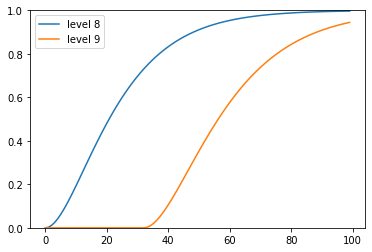

In [144]:
def model_rolldown(level, n_cost, starting_units_num, current_contested, current_uncontested, n_rolls):
    config_rolldown(level, n_cost)
    start = generate_starting_units(starting_units_num)
    stochastic = generate_markov_chain(0, current_contested, current_uncontested, roll_node_improved)
    current_stochastic = np.identity(10)
    rolldown_prob = np.zeros(n_rolls)
    for i in range(n_rolls):
        rolldown_prob[i] = np.matmul(start, current_stochastic)[len(current_stochastic) - 1]
        current_stochastic = np.matmul(current_stochastic, stochastic)
    return rolldown_prob
    
n_cost = 4
starting_units_num = 7
current_contested = 0
current_uncontested = 27
n_rolls = 100
level_to_9_offset = 32 # 64 gold to level
level8_rolldown_prob = model_rolldown(8, n_cost, starting_units_num, current_contested, current_uncontested, n_rolls)
level9_rolldown_prob = model_rolldown(9, n_cost, starting_units_num, current_contested, current_uncontested, n_rolls)
plt.plot(np.arange(n_rolls), level8_rolldown_prob, label="level 8")
plt.plot(np.arange(n_rolls), np.concatenate((np.zeros(level_to_9_offset), level9_rolldown_prob[:(n_rolls - level_to_9_offset)]), axis=None), label="level 9")
plt.legend()
a = plt.ylim(0, 1)

